Econometrics 3, HA 1.

Nikolai Popov, MAE2025.

Download libraries.

In [1]:
import numpy as np # basic linear algebra 
import scipy.stats # for generation of random variables
np.set_printoptions(precision=3) # number of signs after comma in the whole notebook

from tqdm import tqdm # time for cycle

# for graphs
import matplotlib.pyplot as plt 
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF

# for supressing warnings
# import warnings
# warnings.simplefilter("ignore")

## Task 1: Monte-Carlo 

### Task 1.1

1. Generate a sample of (n = 4) observations of $(x_{1i}, x_{2i}, y_i)$ according to their joint distribution.\)

In [2]:
k = 2 # number of independent variables
n = 4 # number of observations - for now - only one
beta_1 = 1
beta_2 = 0.5
sigma_2 = 3

In [3]:
beta = np.array([beta_1, beta_2])[:, np.newaxis] # column vector
X = scipy.stats.norm.rvs(loc=0, scale=1, size=(n, k))
# loc - mean, scale - standard deviation
e = scipy.stats.norm.rvs(loc=0, scale=np.sqrt(sigma_2), size=(n, 1))
print(f'X: {X.shape}\n')
print(f'e: {e.shape}\n')
print(f'beta: {beta.shape}')

X: (4, 2)

e: (4, 1)

beta: (2, 1)


-----------------

$Y = X * \beta + e$

In [4]:
# this is our estimated Y
Y = X @ beta + e
Y.shape

(4, 1)

$\hat{\beta} = (X' X)^{-1} X' Y$

$\hat{\beta}$ is the vector of estimated coefficients.

$X$ is the matrix of predictor variables (also known as the design matrix).

$Y$ is the vector of the target values.

In [5]:
# estimate beta matrix
beta_hat = np.linalg.inv(X.T @ X) @ X.T @ Y

# get particular betas
beta_0_hat = beta_hat[0, 0]
beta_1_hat = beta_hat[1, 0]

print(f'Estimated beta_0_hat: {beta_0_hat}')
print(f'Estimated beta_1_hat: {beta_1_hat}')

Estimated beta_0_hat: 0.7977008371830172
Estimated beta_1_hat: 0.6649438477509211


### Task 1.2 

Calculate $\hat{\theta}$ and $\hat{t_2}$ for this sample.

$\hat{\theta} = \frac{\hat{\beta_1}}{\hat{\beta_2}}$

-----------

$\hat{e} = \hat{Y} - X * \hat{\beta}'$

In [6]:
e_hat = Y - X @ beta_hat
e_hat

array([[0.027],
       [1.034],
       [4.406],
       [2.427]])

In [7]:
e_hat_list = [element[0]**2 for element in e_hat]
e_hat_list

[0.0007040453499756982,
 1.0685085653313966,
 19.412028636057297,
 5.888411405205805]

$\hat{V}_{xe} = \frac{1}{n}X' \Omega X = \frac{1}{n}\sum_{i=1}^n x_i x_i' \hat{e_{i}^{2}}$,

where $\Omega$ is a diagonal matrix with error term $\hat{e_{i}^{2}}$ on the $i_{}^{th}$ place.

In [8]:
# calculate V_hat

V_hat = 0
for i in range(n):
    V_hat += X[i][:, np.newaxis] @ X[i][np.newaxis, :] * e_hat[i]**2
V_hat = V_hat/n
V_hat

array([[3.837, 2.007],
       [2.007, 1.171]])

Now let's check whether we can do the same, using matrix operations.

In [9]:
Omega = np.diag(e_hat_list)
Omega

array([[7.040e-04, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 1.069e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 1.941e+01, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 5.888e+00]])

In [10]:
X.T @ Omega @ X/n

array([[3.837, 2.007],
       [2.007, 1.171]])

Yes, we can)

$\hat{\theta} = \frac{\hat{\beta_1}}{\hat{\beta_2}}$

In [11]:
# calculate teta
teta = beta_1/beta_2
teta_hat = beta_0_hat / beta_1_hat
print(f'Theoretical theta: {teta}')
print(f'Sample theta: {round(teta_hat, 1)}')

Theoretical theta: 2.0
Sample theta: 1.2


$\hat{Q}_{xx} = \frac{1}{n}X' X$ = $\frac{1}{n}\sum_{i=1}^n x_i x_i'$

In [12]:
# calculate Qxx_hat
Qxx_hat = X.T @ X/n
Qxx_hat

array([[0.45 , 0.264],
       [0.264, 0.68 ]])

$t_\theta = \frac{\sqrt{n}(\hat{\theta} - \theta)}{\sqrt{(1/\hat{\beta}_2, -\hat{\beta}_1/\hat{\beta_{2}^{2}})\hat{Q}_{xx}^{-1}\hat{V}_{xe}\hat{Q}_{xx}^{-1}(1/\hat{\beta}_2, -\hat{\beta}_1/\hat{\beta_{2}^{2}})'}}$

In [13]:
beta_sandwich = np.array([(1/beta_1_hat), (-beta_0_hat/beta_1_hat**2)])[np.newaxis, :]
beta_sandwich.shape

(1, 2)

In [14]:
t_teta = np.sqrt(n)*(teta_hat - teta)/(np.sqrt(beta_sandwich@np.linalg.inv(Qxx_hat)\
@V_hat@np.linalg.inv(Qxx_hat)@(beta_sandwich.T)))
t_teta = t_teta[0][0]
t_teta

-0.21599256372901776

In [15]:
print(f'answer:\n theta:{teta_hat} \n t: {t_teta}')

answer:
 theta:1.1996514290358922 
 t: -0.21599256372901776


### Task 1.3

Repeat this R = 10; 000 time

In [16]:
def Monte_Carlo(n_, R):
    '''
    Function to simulate OLS with n observations and k independent variables, calculate teta estimator and its t-statistics.
    Repeat R times.
    '''
    k = 2 # number of independent variables
    # print(f'current n: {n_}')
    beta_1 = 1
    beta_2 = 0.5
    sigma_2 = 3
    Theta = {'theta_hat':[], 't_theta':[]}
    for i in tqdm(range(R)):
        # Create data generating process
        beta = np.array([beta_1, beta_2])[:, np.newaxis]
        X = scipy.stats.norm.rvs(loc=0, scale=1, size=(n_, k))
        e = scipy.stats.norm.rvs(loc=0, scale=np.sqrt(sigma_2), size=(n_, 1))
        Y = X @ beta + e

        # Estimate parameter beta and sample error term
        beta_hat = np.linalg.inv(X.T @ X) @ X.T @ Y
        beta_0_hat = beta_hat[0, 0]
        beta_1_hat = beta_hat[1, 0]
        e_hat = Y - X @ beta_hat
        e_hat_list = [element[0]**2 for element in e_hat]
    
        # Receive required estimators teta and their t-stat
        teta_hat = beta_0_hat / beta_1_hat
        
        Omega = np.diag(e_hat_list)
        V_hat = X.T @ Omega @ X/n_
        Qxx_hat = X.T @ X/n_
        beta_sandwich = np.array([(1/beta_1_hat), (-beta_0_hat/beta_1_hat**2)])[np.newaxis, :]
        
        t_teta = np.sqrt(n)*(teta_hat - teta)/(np.sqrt(beta_sandwich@np.linalg.inv(Qxx_hat)\
        @V_hat@np.linalg.inv(Qxx_hat)@(beta_sandwich.T)))
        
        t_teta = t_teta[0][0]

        # Append to our dictionary the results
        Theta['theta_hat'].append(teta_hat)
        Theta['t_theta'].append(t_teta)
    print(f'Y size: {Y.shape}')
    return(Theta)

In [17]:
# use our function
R = 10000
n = 4
Theta_4 = Monte_Carlo(n, R)

100%|██████████| 10000/10000 [00:01<00:00, 6166.11it/s]

Y size: (4, 1)


In [18]:
# first 5 elements in our keys
for key, value in Theta_4.items():
    print(f'{key}: {value[:5]}')

theta_hat: [-5.173070631573684, -36.799012044241834, -0.20635555721846768, 4.660825730816232, 0.1680730159144061]
t_theta: [-2.0614313187163043, -0.32841228648744686, -11.077203733189963, 0.10052485595557498, -1.3219695264995612]


## Task 2: Asymptotic vs Simulated (n = 4)

Plot the asymptotic and simulated exact cumulative distributions on the same graph.

This is our factual simulated distribution of theta estimator:

$\sqrt n (\hat{\theta} - \theta) \xrightarrow{\mathcal{D}} N(0,1)$, then $E(\hat{\theta}) = 2$, $V(\hat{\theta}) = 60/n$

Based on it, we construct its t-stat, given the following formula:

$t_\theta = \frac{\sqrt{n}(\hat{\theta} - \theta)}{\sqrt{(1/\hat{\beta}_2, -\hat{\beta}_1/\hat{\beta_{2}^{2}})\hat{Q}_{xx}^{-1}\hat{V}_{xe}\hat{Q}_{xx}^{-1}(1/\hat{\beta}_2, -\hat{\beta}_1/\hat{\beta_{2}^{2}})'}}$

This is our asymptotic distribution of this t-stat (given to us "from above"):

$t_\theta \xrightarrow{\mathcal{D}} N(0,1)$

Our task is to compare them, and anayze the accuracy of our approximations (how close our 10,000 repetiotions are to the asymptotic result). For that we will use CDF and ECDF (empirical analogue) functions. 

In [19]:
exp_teta = 2
var_teta = 60/n

Then apply the principle of three sigmas;

95% of the mass of $\theta$ values is inside the following interval:

$E(\theta) \pm 3\sqrt{V(\theta)}$

We will need it to set the axis for our graph correctly.

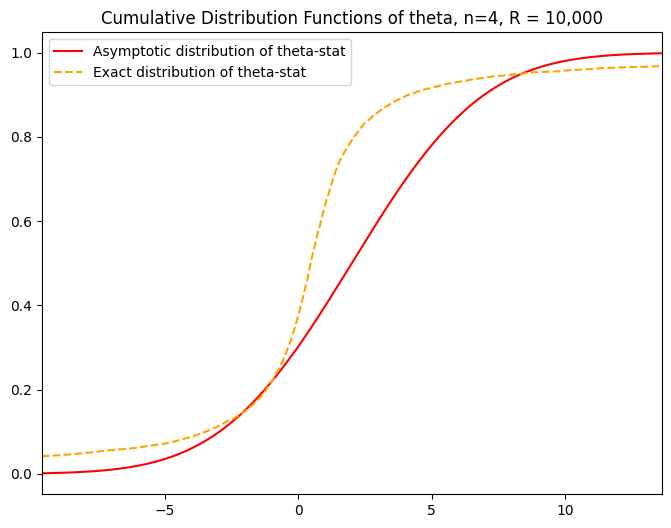

In [20]:
# asymptotic - our Monte-Carlo obtained distribution

fig = plt.figure(figsize=(8,6))

x_axis = np.linspace(exp_teta - 3*np.sqrt(var_teta), exp_teta + 3*np.sqrt(var_teta), 1000000) 

# asymptotic distribution (generated strandard normal CDF) 
plt.plot(x_axis, scipy.stats.norm.cdf(x_axis, exp_teta, np.sqrt(var_teta)), color='red', label='Asymptotic distribution of theta-stat')

# our exact simulated by Monte-Carlo distribution (constructed ECDF, by repetions)
plt.plot(x_axis, ECDF(Theta_4['theta_hat'])(x_axis), label='Exact distribution of theta-stat', linestyle='dashed',  color='orange');
# (x_axis) - to ECDF(Theta_4['theta_hat'])) by the indexes of the axis, not of the Theta_4['theta_hat']) list
plt.legend()

plt.xlim(exp_teta - 3*np.sqrt(var_teta), exp_teta + 3*np.sqrt(var_teta))

plt.title('Cumulative Distribution Functions of theta, n=4, R = 10,000')
plt.savefig('theta-stat_4_10_4.png')
plt.show()

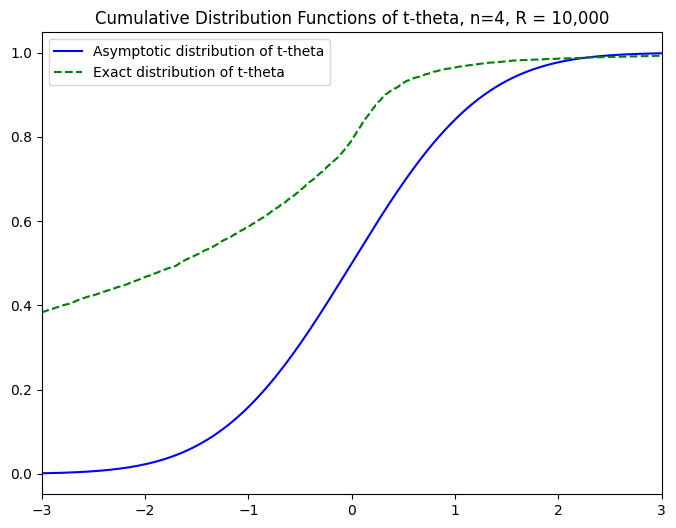

In [21]:
fig = plt.figure(figsize=(8,6))

# this is the mass 95% for N(0,1) - because our theta-stat is N(0,1) (given)
x_axis = np.linspace(-3, 3, 100000)

# asymptotic
plt.plot(x_axis, scipy.stats.norm.cdf(x_axis, 0, 1), color='blue', label='Asymptotic distribution of t-theta')

# our generated
plt.plot(x_axis, ECDF(Theta_4['t_theta'])(x_axis), label='Exact distribution of t-theta', color = 'green', linestyle='dashed');

plt.legend()

plt.xlim((-3, 3))

plt.title('Cumulative Distribution Functions of t-theta, n=4, R = 10,000')
plt.savefig('t-theta_4_10_4.png')
plt.show()

## Task 3:  Asymptotic vs Simulated (n = 20)

The code for parts in task 1 are the same, only shapes change from n=4 to n =20. Thus, let's repeat task 2, to compare the graphs. They might differ. 

100%|██████████| 10000/10000 [00:01<00:00, 5843.42it/s]


Y size: (20, 1)


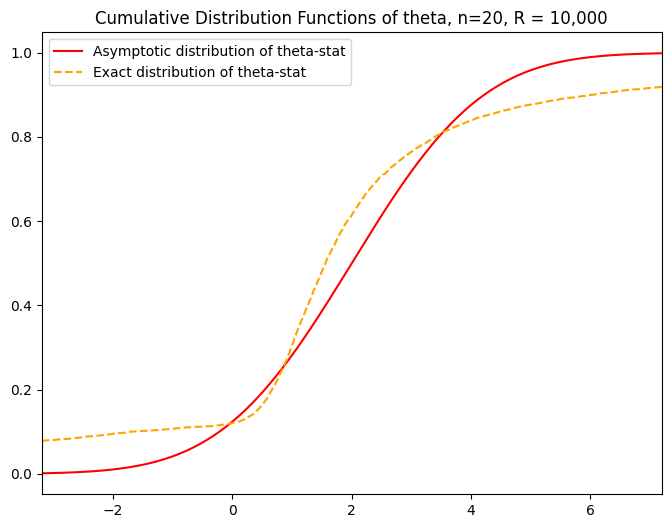

In [22]:
n = 20
R = 10000
Theta_20 = Monte_Carlo(n, R)
exp_teta = 2
var_teta = 60/n

# asymptotic - our Monte-Carlo obtained distribution

fig = plt.figure(figsize=(8,6))

x_axis = np.linspace(exp_teta - 3*np.sqrt(var_teta), exp_teta + 3*np.sqrt(var_teta), 1000000) 

# asymptotic distribution (generated strandard normal CDF) 
plt.plot(x_axis, scipy.stats.norm.cdf(x_axis, exp_teta, np.sqrt(var_teta)), color='red', label='Asymptotic distribution of theta-stat')

# our exact simulated by Monte-Carlo distribution (constructed ECDF, by repetions)
plt.plot(x_axis, ECDF(Theta_20['theta_hat'])(x_axis), label='Exact distribution of theta-stat', linestyle='dashed',  color='orange');
# (x_axis) - to ECDF(Theta_4['theta_hat'])) by the indexes of the axis, not of the Theta_4['theta_hat']) list
plt.legend()

plt.xlim(exp_teta - 3*np.sqrt(var_teta), exp_teta + 3*np.sqrt(var_teta))

plt.title('Cumulative Distribution Functions of theta, n=20, R = 10,000')
plt.savefig('theta-stat_20_10_4.png')
plt.show()

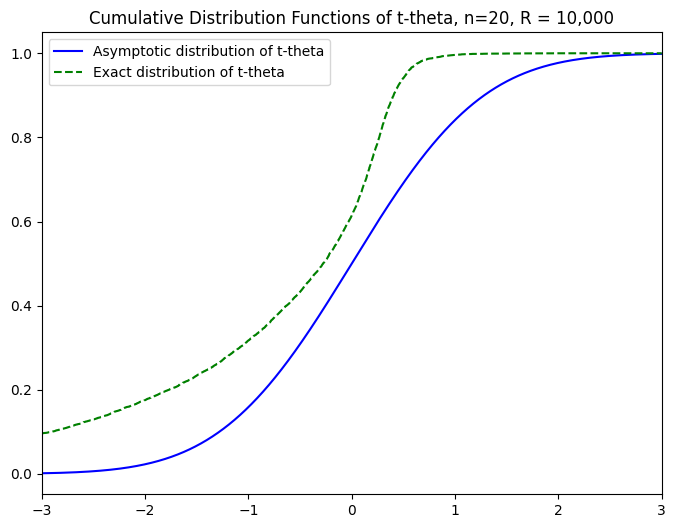

In [23]:
fig = plt.figure(figsize=(8,6))

# this is the mass 95% for N(0,1) - because our theta-stat is N(0,1) (given)
x_axis = np.linspace(-3, 3, 100000)

# asymptotic
plt.plot(x_axis, scipy.stats.norm.cdf(x_axis, 0, 1), color='blue', label='Asymptotic distribution of t-theta')

# our generated
plt.plot(x_axis, ECDF(Theta_20['t_theta'])(x_axis), label='Exact distribution of t-theta', color = 'green', linestyle='dashed');

plt.legend()

plt.xlim((-3, 3))

plt.title('Cumulative Distribution Functions of t-theta, n=20, R = 10,000')
plt.savefig('t-theta_20_10_4.png')
plt.show()

Put all graphs on one chart to compare them. Aslo, I decided to add case with n = 1,000 to see the assumed convergence.

In [24]:
Theta_10_3 = Monte_Carlo(10**3, 10000)

100%|██████████| 10000/10000 [00:35<00:00, 282.87it/s]

Y size: (1000, 1)


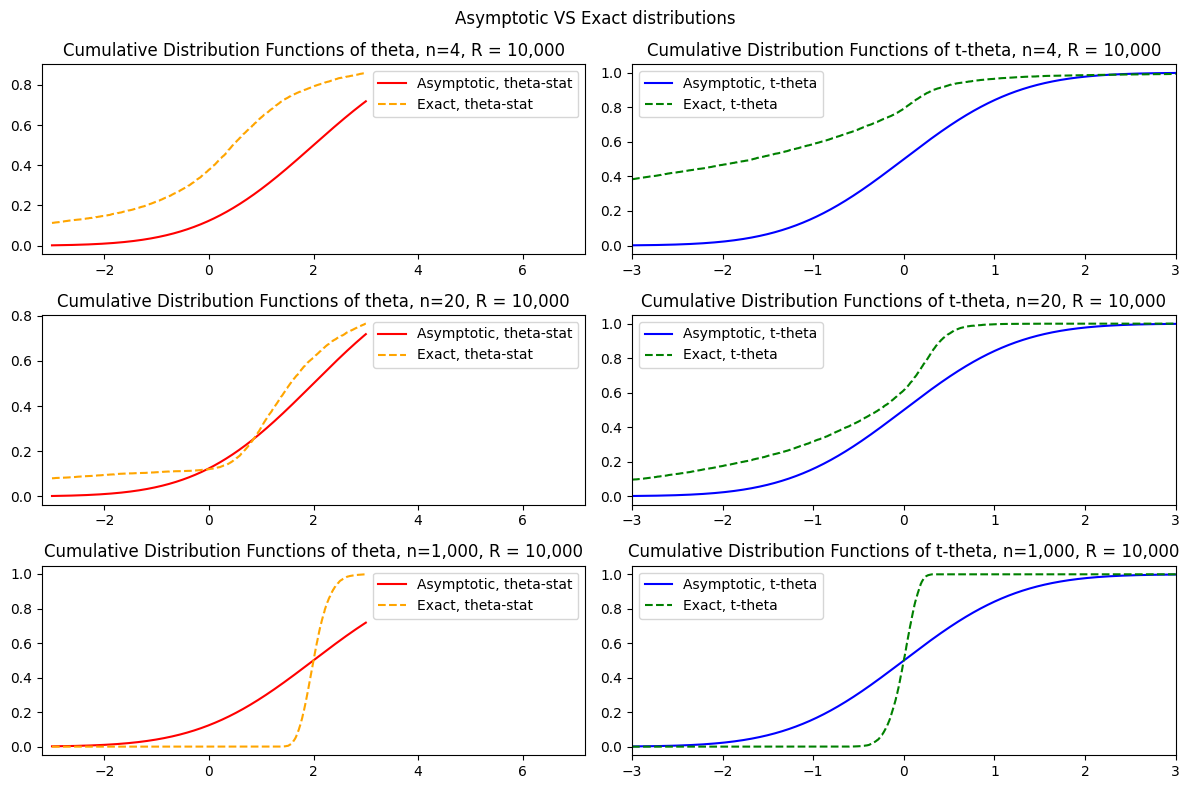

In [25]:
fig, ax = plt.subplots(3, 2, figsize=(12,8))

plt.suptitle('Asymptotic VS Exact distributions')

# Plot 1: Cumulative Distribution Functions of theta, n=4, R = 10,000
ax[0, 0].plot(x_axis, scipy.stats.norm.cdf(x_axis, exp_teta, np.sqrt(var_teta)), color='red', label='Asymptotic, theta-stat')
ax[0, 0].plot(x_axis, ECDF(Theta_4['theta_hat'])(x_axis), label='Exact, theta-stat', linestyle='dashed', color='orange')
ax[0, 0].set_xlim(exp_teta - 3*np.sqrt(var_teta), exp_teta + 3*np.sqrt(var_teta))
ax[0, 0].set_title('Cumulative Distribution Functions of theta, n=4, R = 10,000')
ax[0, 0].legend()

# Plot 2: Cumulative Distribution Functions of t-theta, n=4, R = 10,000
ax[0, 1].plot(x_axis, scipy.stats.norm.cdf(x_axis, 0, 1), color='blue', label='Asymptotic, t-theta')
ax[0, 1].plot(x_axis, ECDF(Theta_4['t_theta'])(x_axis), label='Exact, t-theta', color='green', linestyle='dashed')
ax[0, 1].set_xlim((-3, 3))
ax[0, 1].set_title('Cumulative Distribution Functions of t-theta, n=4, R = 10,000')
ax[0, 1].legend()

# Plot 3: Cumulative Distribution Functions of theta, n=20
ax[1, 0].plot(x_axis, scipy.stats.norm.cdf(x_axis, exp_teta, np.sqrt(var_teta)), color='red', label='Asymptotic, theta-stat')
ax[1, 0].plot(x_axis, ECDF(Theta_20['theta_hat'])(x_axis), label='Exact, theta-stat', linestyle='dashed', color='orange')
ax[1, 0].set_xlim(exp_teta - 3*np.sqrt(var_teta), exp_teta + 3*np.sqrt(var_teta))
ax[1, 0].set_title('Cumulative Distribution Functions of theta, n=20, R = 10,000')
ax[1, 0].legend()

# Plot 4: Cumulative Distribution Functions of theta, n=20
ax[1, 1].plot(x_axis, scipy.stats.norm.cdf(x_axis, 0, 1), color='blue', label='Asymptotic, t-theta')
ax[1, 1].plot(x_axis, ECDF(Theta_20['t_theta'])(x_axis), label='Exact, t-theta', color='green', linestyle='dashed')
ax[1, 1].set_xlim((-3, 3))
ax[1, 1].set_title('Cumulative Distribution Functions of t-theta, n=20, R = 10,000')
ax[1, 1].legend()

# Plot 5: Cumulative Distribution Functions of t-theta, n=10**3
ax[2, 0].plot(x_axis, scipy.stats.norm.cdf(x_axis, exp_teta, np.sqrt(var_teta)), color='red', label='Asymptotic, theta-stat')
ax[2, 0].plot(x_axis, ECDF(Theta_10_3['theta_hat'])(x_axis), label='Exact, theta-stat', linestyle='dashed', color='orange')
ax[2, 0].set_xlim(exp_teta - 3*np.sqrt(var_teta), exp_teta + 3*np.sqrt(var_teta))
ax[2, 0].set_title('Cumulative Distribution Functions of theta, n=1,000, R = 10,000')
ax[2, 0].legend()

# Plot 6: Cumulative Distribution Functions of t-theta, n=10**3
ax[2, 1].plot(x_axis, scipy.stats.norm.cdf(x_axis, 0, 1), color='blue', label='Asymptotic, t-theta')
ax[2, 1].plot(x_axis, ECDF(Theta_10_3['t_theta'])(x_axis), label='Exact, t-theta', color='green', linestyle='dashed')
ax[2, 1].set_xlim((-3, 3))
ax[2, 1].set_title('Cumulative Distribution Functions of t-theta, n=1,000, R = 10,000')
ax[2, 1].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.savefig('asym_exact_n.png')
plt.show()

None

We can observe changes, based on the number of observations in our regressions. Intuitively, we should have more accurate results with large n (more accurate $\hat{\beta}$ and $\hat{e}$ and $\hat{\theta}$, $t_{\theta}$). But why does not our exact distribution converge to asymptotic? Because to get close to asymptotic, we have to increase R, not only n (we have to include more repetions, not only increase the accuracy of estimation in each generated distribution).

Now lets try to increase R.

In [26]:
# Delete old variables
del Theta_4
del Theta_20
del Theta_10_3

# create new ones (n = 4)
Theta_n_4_R_10_4 = Monte_Carlo(4, 10**4)

Theta_n_4_R_10_5 = Monte_Carlo(4, 10**5)

Theta_n_4_R_10_6 = Monte_Carlo(4, 10**6)

100%|██████████| 10000/10000 [00:01<00:00, 6094.96it/s]


Y size: (4, 1)


100%|██████████| 100000/100000 [00:15<00:00, 6393.75it/s]


Y size: (4, 1)


100%|██████████| 1000000/1000000 [02:36<00:00, 6371.42it/s]

Y size: (4, 1)


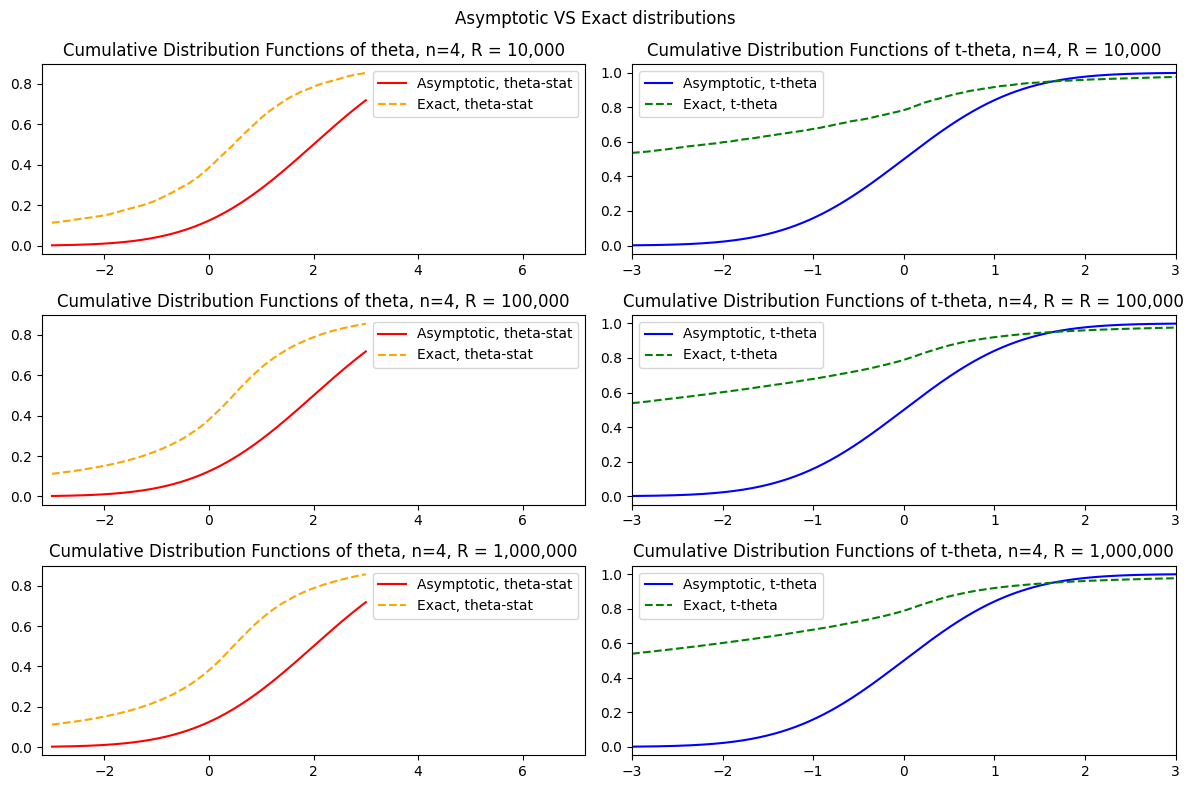

In [27]:
fig, ax = plt.subplots(3, 2, figsize=(12,8))

plt.suptitle('Asymptotic VS Exact distributions')

# Plot 1: Cumulative Distribution Functions of theta, n=4, R = 10,000
ax[0, 0].plot(x_axis, scipy.stats.norm.cdf(x_axis, exp_teta, np.sqrt(var_teta)), color='red', label='Asymptotic, theta-stat')
ax[0, 0].plot(x_axis, ECDF(Theta_n_4_R_10_4['theta_hat'])(x_axis), label='Exact, theta-stat', linestyle='dashed', color='orange')
ax[0, 0].set_xlim(exp_teta - 3*np.sqrt(var_teta), exp_teta + 3*np.sqrt(var_teta))
ax[0, 0].set_title('Cumulative Distribution Functions of theta, n=4, R = 10,000')
ax[0, 0].legend()

# Plot 2: Cumulative Distribution Functions of t-theta, n=4, R = 10,000
ax[0, 1].plot(x_axis, scipy.stats.norm.cdf(x_axis, 0, 1), color='blue', label='Asymptotic, t-theta')
ax[0, 1].plot(x_axis, ECDF(Theta_n_4_R_10_4['t_theta'])(x_axis), label='Exact, t-theta', color='green', linestyle='dashed')
ax[0, 1].set_xlim((-3, 3))
ax[0, 1].set_title('Cumulative Distribution Functions of t-theta, n=4, R = 10,000')
ax[0, 1].legend()

# Plot 3: Cumulative Distribution Functions of theta, n=20
ax[1, 0].plot(x_axis, scipy.stats.norm.cdf(x_axis, exp_teta, np.sqrt(var_teta)), color='red', label='Asymptotic, theta-stat')
ax[1, 0].plot(x_axis, ECDF(Theta_n_4_R_10_5['theta_hat'])(x_axis), label='Exact, theta-stat', linestyle='dashed', color='orange')
ax[1, 0].set_xlim(exp_teta - 3*np.sqrt(var_teta), exp_teta + 3*np.sqrt(var_teta))
ax[1, 0].set_title('Cumulative Distribution Functions of theta, n=4, R = 100,000')
ax[1, 0].legend()

# Plot 4: Cumulative Distribution Functions of theta, n=20
ax[1, 1].plot(x_axis, scipy.stats.norm.cdf(x_axis, 0, 1), color='blue', label='Asymptotic, t-theta')
ax[1, 1].plot(x_axis, ECDF(Theta_n_4_R_10_5['t_theta'])(x_axis), label='Exact, t-theta', color='green', linestyle='dashed')
ax[1, 1].set_xlim((-3, 3))
ax[1, 1].set_title('Cumulative Distribution Functions of t-theta, n=4, R = R = 100,000')
ax[1, 1].legend()

# Plot 5: Cumulative Distribution Functions of t-theta, n=10**3
ax[2, 0].plot(x_axis, scipy.stats.norm.cdf(x_axis, exp_teta, np.sqrt(var_teta)), color='red', label='Asymptotic, theta-stat')
ax[2, 0].plot(x_axis, ECDF(Theta_n_4_R_10_6['theta_hat'])(x_axis), label='Exact, theta-stat', linestyle='dashed', color='orange')
ax[2, 0].set_xlim(exp_teta - 3*np.sqrt(var_teta), exp_teta + 3*np.sqrt(var_teta))
ax[2, 0].set_title('Cumulative Distribution Functions of theta, n=4, R = 1,000,000')
ax[2, 0].legend()

# Plot 6: Cumulative Distribution Functions of t-theta, n=10**3
ax[2, 1].plot(x_axis, scipy.stats.norm.cdf(x_axis, 0, 1), color='blue', label='Asymptotic, t-theta')
ax[2, 1].plot(x_axis, ECDF(Theta_n_4_R_10_6['t_theta'])(x_axis), label='Exact, t-theta', color='green', linestyle='dashed')
ax[2, 1].set_xlim((-3, 3))
ax[2, 1].set_title('Cumulative Distribution Functions of t-theta, n=4, R = 1,000,000')
ax[2, 1].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.savefig('asym_exact_R.png')
plt.show()

None

Unexpectedly, we are not getting closer to the asymptotic distributions.

Now let's increase both n and R.

In [28]:
# Delete old variables
del Theta_n_4_R_10_4
del Theta_n_4_R_10_5
del Theta_n_4_R_10_6

# create new ones (n = 4)
Theta_n_4_R_10_4 = Monte_Carlo(4, 10**4)

Theta_n_20_R_10_5 = Monte_Carlo(20, 10**5)

Theta_n_1000_R_10_6 = Monte_Carlo(1000, 10**6)

100%|██████████| 10000/10000 [00:01<00:00, 6369.00it/s]


Y size: (4, 1)


100%|██████████| 100000/100000 [00:16<00:00, 5912.15it/s]


Y size: (20, 1)


100%|██████████| 1000000/1000000 [55:10<00:00, 302.09it/s] 

Y size: (1000, 1)


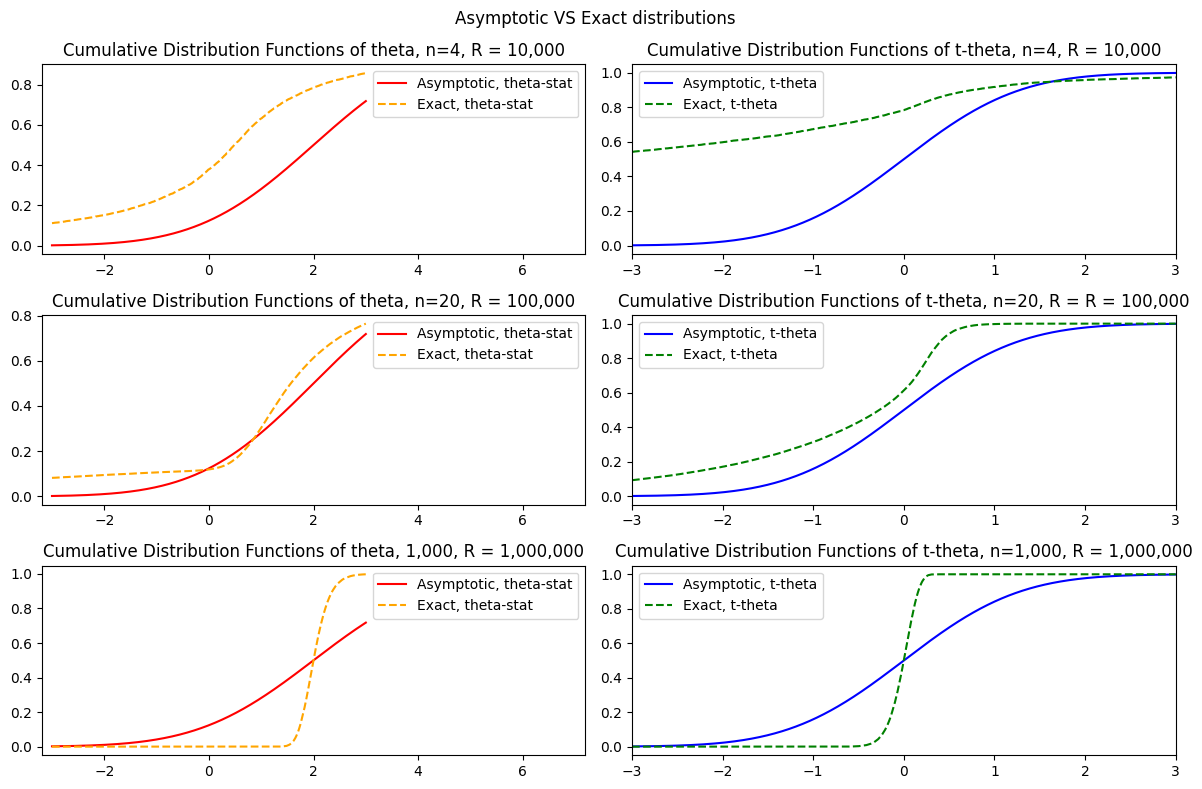

In [29]:
fig, ax = plt.subplots(3, 2, figsize=(12,8))

plt.suptitle('Asymptotic VS Exact distributions')

# Plot 1: Cumulative Distribution Functions of theta, n=4, R = 10,000
ax[0, 0].plot(x_axis, scipy.stats.norm.cdf(x_axis, exp_teta, np.sqrt(var_teta)), color='red', label='Asymptotic, theta-stat')
ax[0, 0].plot(x_axis, ECDF(Theta_n_4_R_10_4['theta_hat'])(x_axis), label='Exact, theta-stat', linestyle='dashed', color='orange')
ax[0, 0].set_xlim(exp_teta - 3*np.sqrt(var_teta), exp_teta + 3*np.sqrt(var_teta))
ax[0, 0].set_title('Cumulative Distribution Functions of theta, n=4, R = 10,000')
ax[0, 0].legend()

# Plot 2: Cumulative Distribution Functions of t-theta, n=4, R = 10,000
ax[0, 1].plot(x_axis, scipy.stats.norm.cdf(x_axis, 0, 1), color='blue', label='Asymptotic, t-theta')
ax[0, 1].plot(x_axis, ECDF(Theta_n_4_R_10_4['t_theta'])(x_axis), label='Exact, t-theta', color='green', linestyle='dashed')
ax[0, 1].set_xlim((-3, 3))
ax[0, 1].set_title('Cumulative Distribution Functions of t-theta, n=4, R = 10,000')
ax[0, 1].legend()

# Plot 3: Cumulative Distribution Functions of theta, n=20
ax[1, 0].plot(x_axis, scipy.stats.norm.cdf(x_axis, exp_teta, np.sqrt(var_teta)), color='red', label='Asymptotic, theta-stat')
ax[1, 0].plot(x_axis, ECDF(Theta_n_20_R_10_5['theta_hat'])(x_axis), label='Exact, theta-stat', linestyle='dashed', color='orange')
ax[1, 0].set_xlim(exp_teta - 3*np.sqrt(var_teta), exp_teta + 3*np.sqrt(var_teta))
ax[1, 0].set_title('Cumulative Distribution Functions of theta, n=20, R = 100,000')
ax[1, 0].legend()

# Plot 4: Cumulative Distribution Functions of theta, n=20
ax[1, 1].plot(x_axis, scipy.stats.norm.cdf(x_axis, 0, 1), color='blue', label='Asymptotic, t-theta')
ax[1, 1].plot(x_axis, ECDF(Theta_n_20_R_10_5['t_theta'])(x_axis), label='Exact, t-theta', color='green', linestyle='dashed')
ax[1, 1].set_xlim((-3, 3))
ax[1, 1].set_title('Cumulative Distribution Functions of t-theta, n=20, R = R = 100,000')
ax[1, 1].legend()

# Plot 5: Cumulative Distribution Functions of t-theta, n=10**3
ax[2, 0].plot(x_axis, scipy.stats.norm.cdf(x_axis, exp_teta, np.sqrt(var_teta)), color='red', label='Asymptotic, theta-stat')
ax[2, 0].plot(x_axis, ECDF(Theta_n_1000_R_10_6['theta_hat'])(x_axis), label='Exact, theta-stat', linestyle='dashed', color='orange')
ax[2, 0].set_xlim(exp_teta - 3*np.sqrt(var_teta), exp_teta + 3*np.sqrt(var_teta))
ax[2, 0].set_title('Cumulative Distribution Functions of theta, 1,000, R = 1,000,000')
ax[2, 0].legend()

# Plot 6: Cumulative Distribution Functions of t-theta, n=10**3
ax[2, 1].plot(x_axis, scipy.stats.norm.cdf(x_axis, 0, 1), color='blue', label='Asymptotic, t-theta')
ax[2, 1].plot(x_axis, ECDF(Theta_n_1000_R_10_6['t_theta'])(x_axis), label='Exact, t-theta', color='green', linestyle='dashed')
ax[2, 1].set_xlim((-3, 3))
ax[2, 1].set_title('Cumulative Distribution Functions of t-theta, n=1,000, R = 1,000,000')
ax[2, 1].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.savefig('asym_exact_N_R.png')
plt.show()

None

Here we still do not get converge to asymptotics for $\theta$ and $t_{\theta}$. 